In [41]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    EnsureChannelFirstd,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations # Ist für die Visualisierung und Analyse der Aktivierunsfunktionen. Wird meist auf Evaluation angewendet
    
)

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference

In [2]:
in_dir = 'Liver'
model_dir = 'Liver/results'

In [9]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_test.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_test.npy'))

print(train_metric, train_loss)

[0.42312681 0.42491623 0.42654393 0.42813458 0.42969486 0.43120393
 0.43265018 0.43403977 0.43538006 0.43667781] [0.57687319 0.57508377 0.57345607 0.57186542 0.57030514 0.56879607
 0.56734982 0.56596023 0.56461994 0.56332219]


In [13]:
from datetime import date
time = date.today()

2023-09-22


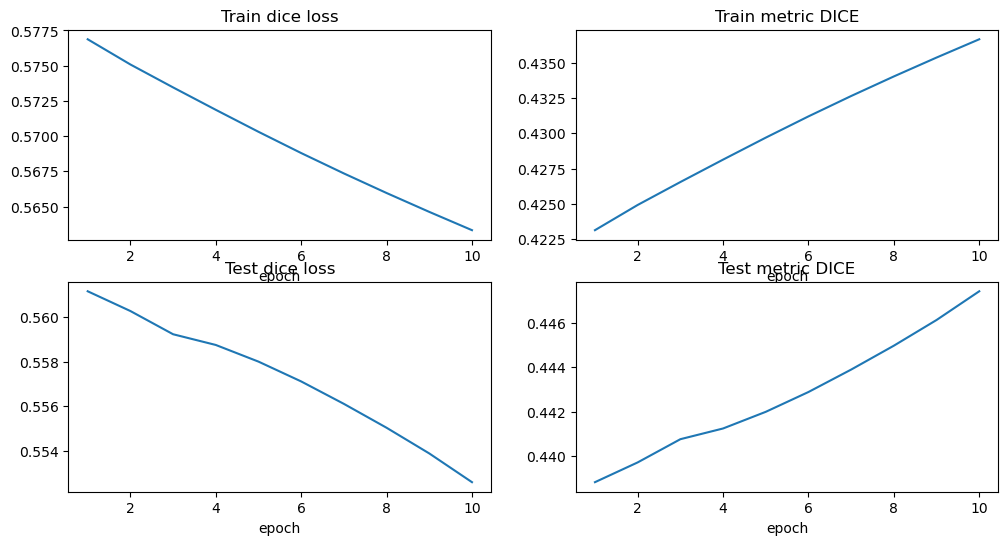

In [36]:
plt.figure(f'Results of {time}', (12, 6))
plt.subplot(2, 2, 1)
plt.title('Train dice loss')
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title('Train metric DICE')
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title('Test dice loss')
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel('epoch')
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title('Test metric DICE')
x = [i + 1 for i in range(len(test_metric))]
y = test_metric
plt.xlabel('epoch')
plt.plot(x, y)

plt.show()


In [37]:
path_train_volumes = sorted(glob(os.path.join(in_dir,'nifti_files', 'TrainVolumes', '*.nii.gz')))
path_train_segmentations = sorted(glob(os.path.join(in_dir, 'nifti_files', 'TrainSegmentation', '*.nii.gz')))

path_test_volumes = sorted(glob(os.path.join(in_dir, 'nifti_files', 'TestVolumes', '*.nii.gz')))
path_test_segmentations = sorted(glob(os.path.join(in_dir, 'nifti_files', 'TestSegmentation', '*nii.gz')))

train_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentations)]
test_files = [{'vol': image_name, 'seg': label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentations)]
test_files = test_files[0:9] # wenn weniger als neun wird das Vorhandene übertragen

In [42]:
test_transforms = Compose([
    LoadImaged(keys = ['vol', 'seg']),
    EnsureChannelFirstd(keys = ['vol', 'seg']),
    Spacingd(keys = ['vol', 'seg'], pixdim = (1.5, 1.5, 1), mode = ('bilinear', 'nearest')),
    Orientationd(keys = ['vol', 'seg'], axcodes = 'RAS'),
    ScaleIntensityRanged(keys = ['vol', 'seg'], a_min = -200, a_max = 200, b_min = 0.0, b_max = 1.0, clip = True),
    CropForegroundd(keys = ['vol', 'seg'], source_key = 'vol'),
    Resized(keys = ['vol', 'seg'], spatial_size = (128, 128, 64)),
    ToTensord(keys = ['vol', 'seg']),
    
])

In [43]:
test_ds = Dataset(data = test_files, transform = test_transforms)
test_loader = DataLoader(test_ds, batch_size = 1)

In [50]:
device = torch.device('cpu')
model = UNet(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16, 32, 64, 128, 256),
    strides = (2, 2, 2, 2),
    num_res_units = 2,
    norm = Norm.BATCH,
).to(device)

In [ ]:
model.load_state_dict(torch.load(os.path.join(model_dir, 'best_metric_model.pth')))
model.test()

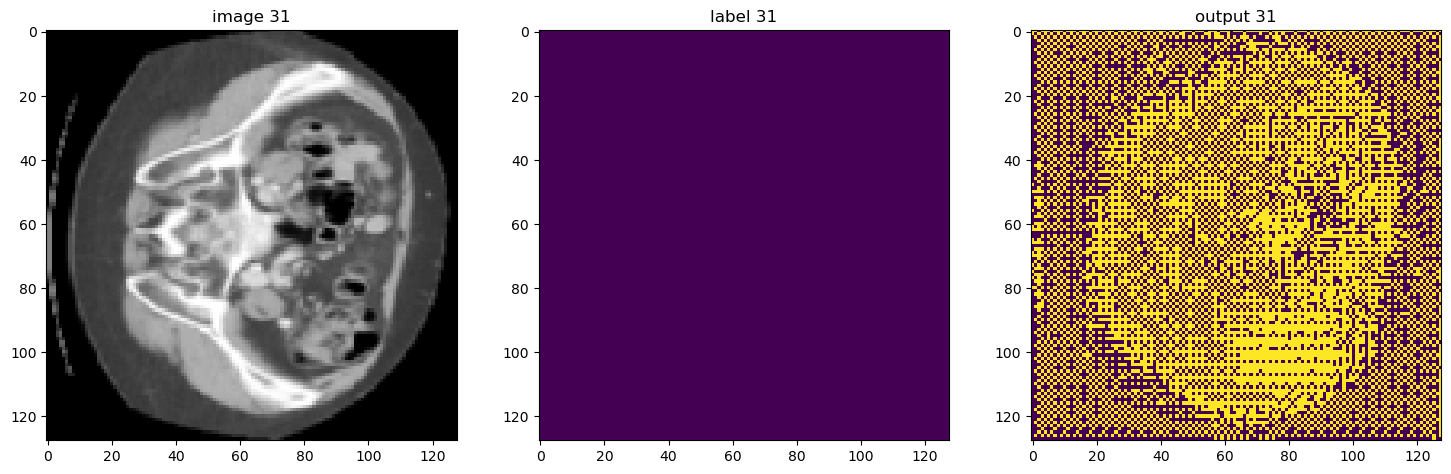

In [58]:
sw_batch_size = 4
roi_size = (128, 128, 64)# roi bedeutet point of interest
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']
    #t_segmentation = test_patient['seg']
    
    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid = True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.53
    
    for i in range(32):
        
        plt.figure('check', (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f'image {i}')
        plt.imshow(test_patient['vol'][0, 0, :, :, i], cmap = 'gray')
        
        plt.subplot(1, 3, 2)
        plt.title(f'label {i}')
        plt.imshow(test_patient['seg'][0, 0, :, :, i] != 0)
        
        plt.subplot(1, 3, 3)
        plt.title(f'output {i}')
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i])
        
        plt.show
        